# Mini Project 1
## News Comparison Analysis

In [1]:
# Let's import the required libraries
from bs4 import BeautifulSoup
import requests
import csv
import time
import math
import pandas as pd
import numpy as np
import string
from collections import  Counter
# Libraries for data visualization
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
current_palette = sns.color_palette()
# nlp library
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy

     |████████████████████████████████| 12.0 MB 7.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# selenium and web driver installations for chrome
# source: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/gra

### Step 1: Webscraping
For this mini project, I have scraped data from New York Times. The archive has an extensive collection of articles on a wide range of topics. 

In [3]:
def newsscraper(url):
    """
    Scrapes a webpage for news items using selenium for dynamic loading
    
    Parameters
    ----------
    url : str
        url to be scraped
    
    Returns
    -------
        html of provided url
    """

    # selenium web driver
    driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
    driver.get(url)
    
    # This XPATH represents the Load More button at the bottom of the NY Times page
    xpth = '//*[@id="site-content"]/div/div[2]/div[2]/div/button'

    # Initially, there are 10 news items on the NYTimes page indicated by variable prev
    prev = 10
    new = 0
    check = 3

    # if the number of news elements on the page doesn't change after clicking the
    # Load More button 3 times, exit the loop.
    while check !=0:
          if prev == new:
            check -= 1
          prev= len(driver.find_elements_by_class_name('css-2fgx4k'))
          # When the button is clicked, new items will be loaded
          try:
              # find the button from its xpath and click it
              button = driver.find_element_by_xpath(xpth)
              button.click()
          except:
              # end of search results
              print("No more search result available")
              break
          # Wait for 1 second so that the new items get loaded
          time.sleep(1)
          new = len(driver.find_elements_by_class_name('css-2fgx4k'))
    return driver.page_source.encode('utf-8')

The newsscraper function scrapes news for the first two weeks of December 2019 and 2020. The scraping takes around 8 minutes so please allow this to run for a while.
If you receive a time out error, it is likely to be an internet problem. Re-run the cell in that scenario.

In [4]:
# urls to be scraped
urls = ["https://www.nytimes.com/search?dropmab=true&endDate=20191214&query=&sort=best&startDate=20191201&types=article",
        "https://www.nytimes.com/search?dropmab=true&endDate=20201214&query=&sort=best&startDate=20201201&types=article"]
html_2019 = newsscraper(urls[0])
html_2020 = newsscraper(urls[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: use options instead of chrome_options
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: use options instead of chrome_options
  app.launch_new_instance()


### Step 2: Data Processing
In this step, the news scraped from the archives is processed through BeautifulSoup and the following information is extracted


1.   News Title
2.   News Author
3.   News Date
4.   News Link
5.   News Category



In [5]:
soup_2019 = BeautifulSoup(html_2019, 'lxml')
soup_2020 = BeautifulSoup(html_2020, 'lxml')

In [6]:
news_dfs = []
for soup in [soup_2019, soup_2020]:
  i = 0
  # Get all the news elements from the loaded news website
  News_elements = soup.find_all('li',class_='css-1l4w6pd') 
  news_df= pd.DataFrame(index=np.arange(0, len(News_elements)), 
                        columns = ['ID', 'title', 'author', 'date', 'category', 'url'])
  
  # For each News item, find title, author, date and url
  for News in News_elements:
      title = News.find('div',class_='css-1i8vfl5').h4.text
      author = News.find('p',class_='css-15w69y9')
      # On NY times archive webpage, some author names are missing.
      # So, we have to check for null values before lstrip 
      if author != None:
        author = author.text.lstrip("By ")
      else:
        author = 'Anonymous'
      category = News.find('p',class_='css-myxawk').text
      date = News.find('span',class_='css-17ubb9w').text
      url = 'https://nytimes.com'+ str(News.find('div',class_='css-e1lvw9')).split('href="')[1].split('"')[0]
      # assign an ID based on new number and year
      id = str(i+1)
      news_df.loc[i] = [id, title, author, date, category, url]
      i = i + 1
  news_dfs.append(news_df)


news_df2019 = news_dfs[0]
news_df2019.ID = '2019' + news_df2019.ID.astype('str')
news_df2020 = news_dfs[1]
news_df2020.ID = '2020' + news_df2020.ID.astype('str')

# Concatenating all news items in one single dataframe for ease of use
news_df = news_df2019.append(news_df2020, ignore_index= True)

In [7]:
# cast the column to appropriate data types
news_df['ID'] = news_df['ID'].astype('int')
news_df['title'] = news_df['title'].astype('str')
news_df['author'] = news_df['author'].astype('str')
news_df['date'] =  pd.to_datetime(news_df['date'])
news_df['category'] = news_df['category'].astype('str')
print(news_df.dtypes)

ID                   int64
title               object
author              object
date        datetime64[ns]
category            object
url                 object
dtype: object


In [8]:
# Add new columns for year, day and day of week
news_df['year'] = pd.DatetimeIndex(news_df['date']).year
news_df['day'] = pd.DatetimeIndex(news_df['date']).day
news_df['dayofweek'] = news_df['date'].dt.day_name()

In [9]:
# Let's have a look at our news dataframe
news_df.head()

,ID,title,author,date,category,url,year,day,dayofweek
0,20191,"Richard G. Hatcher, Ex-Mayor of Gary, Ind., an...",Joseph P. Fried,2019-12-14,U.S.,https://nytimes.com/2019/12/14/us/richard-hatc...,2019,14,Saturday
1,20192,Doing a Double Take,Caitlin Lovinger,2019-12-14,Crosswords & Games,https://nytimes.com/2019/12/14/crosswords/dail...,2019,14,Saturday
2,20193,Cory Booker Leads the Charge to Change Debate ...,Reid J. Epstein,2019-12-14,Politics,https://nytimes.com/2019/12/14/us/politics/dem...,2019,14,Saturday
3,20194,Ex-Trump Aide Is Expected to Return to White H...,Maggie Haberman,2019-12-14,Politics,https://nytimes.com/2019/12/14/us/politics/joh...,2019,14,Saturday
4,20195,Italy’s New ‘Sardines’ Movement Packs Piazzas ...,Jason Horowitz,2019-12-14,Europe,https://nytimes.com/2019/12/14/world/europe/it...,2019,14,Saturday


### Data Cleaning
Data is checked for missing and duplicate values

In [10]:
# get info about the news data
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2030 entries, 0 to 2029
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ID         2030 non-null   int64         
 1   title      2030 non-null   object        
 2   author     2030 non-null   object        
 3   date       2030 non-null   datetime64[ns]
 4   category   2030 non-null   object        
 5   url        2030 non-null   object        
 6   year       2030 non-null   int64         
 7   day        2030 non-null   int64         
 8   dayofweek  2030 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 142.9+ KB


In [11]:
# checking for null values, if any
news_df.isnull().sum()

ID           0
title        0
author       0
date         0
category     0
url          0
year         0
day          0
dayofweek    0
dtype: int64

In [12]:
# checking for duplicate rows, if any
news_df.duplicated(subset = news_df.columns[:-2], keep = 'first').sum()

0

## Step 3: Exploratory Data Analysis (EDA)
In this step, the data is analyzed through visualizations. The intent is to reveal hidden stories from the data.

Let's start by analyzing how the volume of news published varies across different days of the week. A column *dayofweek* was created in the dataframe. Let's check if it has any effect on news counts

In [13]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
            'Sunday']
combined = news_df.dayofweek.value_counts()[weekdays]
grouped = news_df.groupby('year').dayofweek.value_counts()[list(zip(*[np.sort(
    [2019, 2020]*7), weekdays*2]))]
temp = pd.DataFrame(columns= ['2019', '2020'])
temp['2019'] = grouped[2019].values
temp['2020'] = grouped[2020].values
temp.index = weekdays

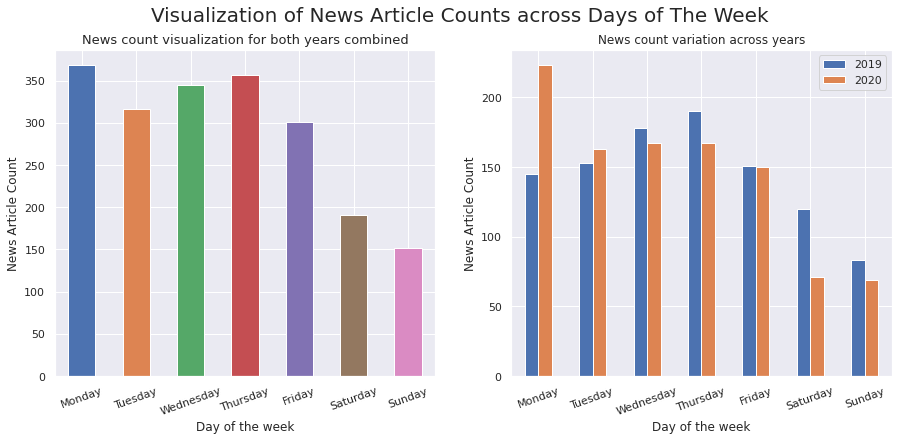

In [14]:
# Sub plot for news article counts across days of the week,
fig1, axes1 = plt.subplots(1, 2, figsize = (15,6))
fig1.suptitle('Visualization of News Article Counts across Days of The Week',
              fontsize = 20)

axes1[0].set_title('News count visualization for both years combined', 
                   fontsize = 13)
combined.plot(kind='bar', ax=axes1[0], color = current_palette)
axes1[0].set_xlabel('Day of the week')
axes1[0].set_ylabel('News Article Count')
axes1[0].set_xticklabels(weekdays, rotation= 20);

# grouped bar chart to compare news article counts between 2019 and 2020
axes1[1].set_title('News count variation across years')
temp.plot(kind='bar', ax=axes1[1], color = current_palette)
axes1[1].set_xlabel('Day of the week')
axes1[1].set_ylabel('News Article Count');
axes1[1].set_xticklabels(weekdays, rotation= 20);

#### Insights
The plots indicate that the news article count was higher on weekdays as compared to weekends. This trend was similar across both years. Let's visualize if there is any difference in the categories of articles published on weekends vs weekdays


In [15]:
# lambda function to differentiate between weekdays and weekends
def is_weekend(row):
  if row['dayofweek'] == 'Sunday':
    return True
  if row['dayofweek'] == 'Saturday':
    return True
  else:
    return False
news_df['is_weekend'] = news_df.apply(lambda row : is_weekend(row), axis = 1) 


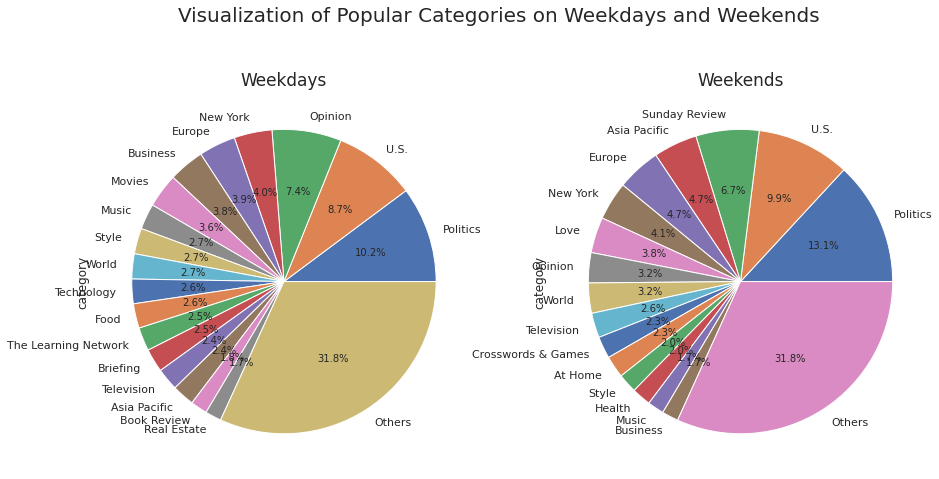

In [16]:
threshold = 1.6
# visualize popular categories
fig1, axes1 = plt.subplots(1, 2, figsize = (17,7))
fig1.suptitle('Visualization of Popular Categories on Weekdays and Weekends',
              fontsize = 20)

axes1[0].set_title('Weekdays', fontsize = 17)
temp = news_df[~news_df.is_weekend].category.value_counts(normalize=True)*100
temp['Others'] = temp[temp< threshold].sum()
temp[temp>= threshold].plot(kind='pie', figsize = (15,8), ax=axes1[0],autopct='%1.1f%%')

axes1[1].set_title('Weekends', fontsize = 17)
temp = news_df[news_df.is_weekend].category.value_counts(normalize=True)*100
temp['Others'] = temp[temp< threshold].sum()
temp[temp>= threshold].plot(kind='pie', figsize = (15,8), ax=axes1[1],autopct='%1.1f%%')


### Insights
Many news articles related to politics are published on both weekdays and weekends. However, on weekends, crosswords and reviews are published more.
Now, let's see which authors wrote the most articles. Let's plot the top 10 authors (excluding anonymous)

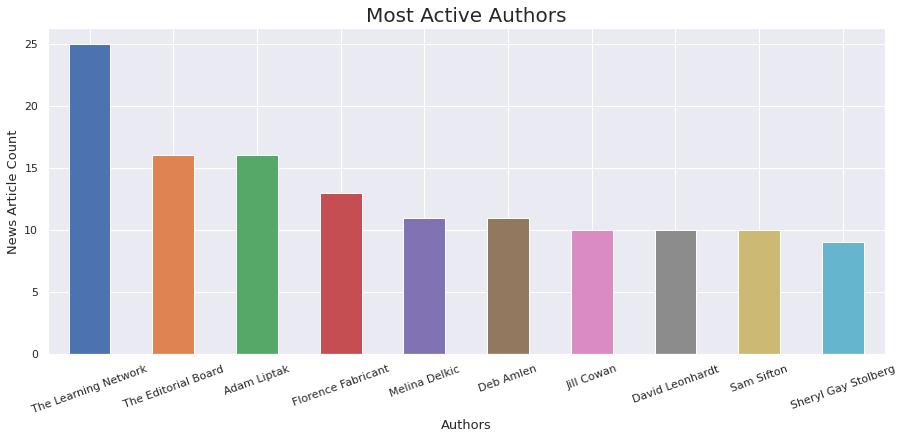

In [17]:
# count author frequency
news_df.author.value_counts()[1:11].plot(kind='bar', figsize=  (15,6), color = current_palette);
plt.xlabel('Authors', fontsize =13)
plt.ylabel('News Article Count', fontsize =13)
plt.title('Most Active Authors', fontsize =20)
plt.xticks(rotation=20);

Let's visualize title lengths in the dataset

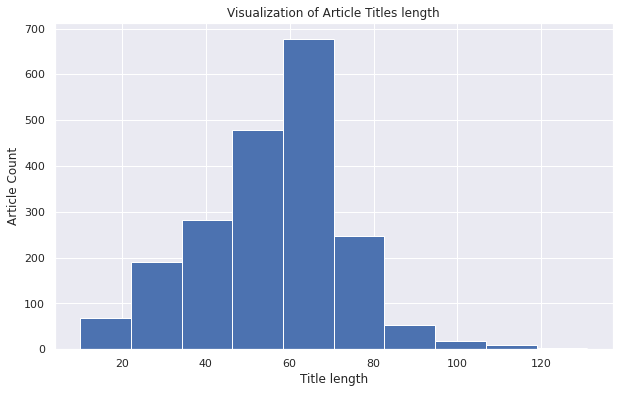

In [18]:
# visualizing title length

plt.figure(figsize=(10,6))
plt.xlabel("Title length")
plt.ylabel("Article Count")
plt.title('Visualization of Article Titles length')

news_df['title'].str.len().hist();


## Step 4: Comparison Analysis Study
Now, let's analyze the broad category provided by the NY Times website.

Text(0.5, 1.0, 'Popular categories')

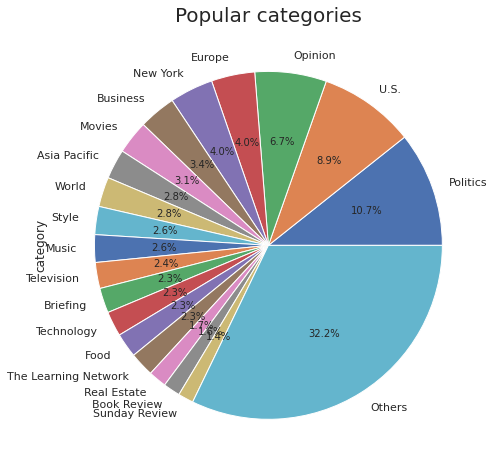

In [19]:
threshold = 1.4
# count the category frequency
temp = news_df.category.value_counts(normalize=True)*100
# group vategories into others for a neater visualization
temp['Others'] = temp[temp< threshold].sum()
temp[temp>= threshold].plot(kind='pie', figsize = (15,8), autopct='%1.1f%%')
plt.title('Popular categories', fontsize = 20)

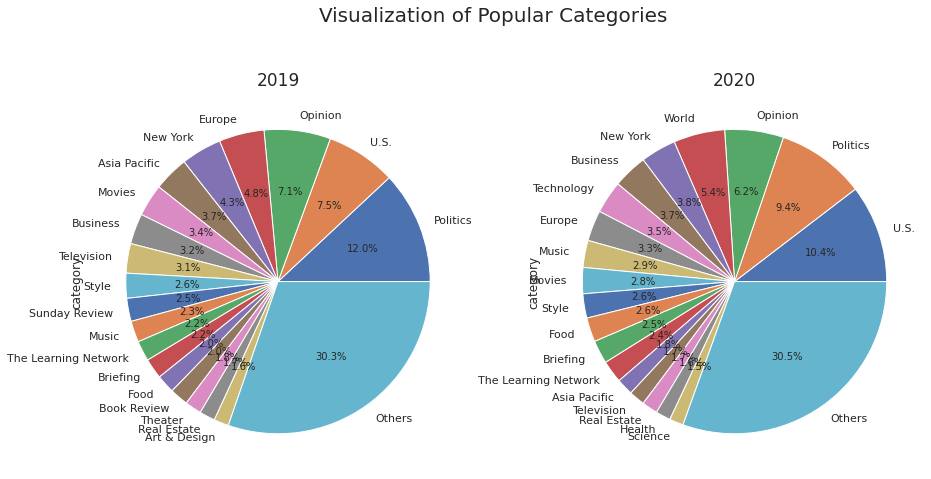

In [20]:
threshold = 1.4

fig1, axes1 = plt.subplots(1, 2, figsize = (17,7))
fig1.suptitle('Visualization of Popular Categories',
              fontsize = 20)

# category distribution for 2019
axes1[0].set_title('2019', fontsize = 17)
temp = news_df[news_df.year == 2019].category.value_counts(normalize=True)*100
temp['Others'] = temp[temp< threshold].sum()
temp[temp>= threshold].plot(kind='pie', figsize = (15,8), ax=axes1[0],autopct='%1.1f%%')

# category distribution for 2020
axes1[1].set_title('2020', fontsize = 17)
temp = news_df[news_df.year == 2020].category.value_counts(normalize=True)*100
temp['Others'] = temp[temp< threshold].sum()
temp[temp>= threshold].plot(kind='pie', figsize = (15,8), ax=axes1[1],autopct='%1.1f%%')


These categories are a little too broad and vague to provide meaningful information. Let's find categories based upon the news titles

In [21]:
# Convert the title into lowercase string
news_df['title'] = news_df['title'].str.lower()

In [22]:
nlp = spacy.load('en_core_web_sm')
# function to remove stop
def remove_stopwords(tokens):
  cleaned_sentence =[] 
  for word in tokens:
    w = nlp.vocab[word]
    if w.is_stop == False:
        cleaned_sentence.append(word)
  print(len(tokens1)-len(cleaned_sentence), ' stopwords were removed' )
  return cleaned_sentence

In [23]:
# combine titles into one big string
str1 = ' '.join(news_df[news_df.year == 2019].title)
str2 = ' '.join(news_df[news_df.year == 2020].title)

# we need to remove the punctuations from the text
for i in string.punctuation:
    str1= str1.replace(i,"")
    str2= str2.replace(i,"")
str1 = str1.replace('’', "")
str2 = str2.replace('’', "")
str1 = str1.replace('2019', "")
str2 = str2.replace('2020', "")
str1 = str1.replace('trumps', "trump")
str2 = str2.replace('trumps', "trump")

text1 = nlp(str1)
text2 = nlp(str2)

# let's tokenize the text
tokens1 = [w.text for w in text1]
tokens2 = [w.text for w in text2]

# Lastly, we will remove the stopwords from the text
cleaned1 = remove_stopwords(tokens1)
cleaned2 = remove_stopwords(tokens2)




3185  stopwords were removed
3222  stopwords were removed


In [24]:
# calculate word frequency
counts1 = Counter(cleaned1)
counts2 = Counter(cleaned2)
x1 = []
y1 = []
x2 = []
y2 = []
z = 0
j = 0
# get top 20 frequent words
while z<=20:
  i = counts1.most_common()[j]
  if len(i[0]) >2:
     x1.append(i[0])
     y1.append(i[1])
     z = z+1
  j = j+1

z = 0
j = 0
while z<=20:
  i = counts2.most_common()[j]
  if len(i[0]) >2:
     x2.append(i[0])
     y2.append(i[1])
     z = z+1
  j = j+1

Text(0, 0.5, 'words')

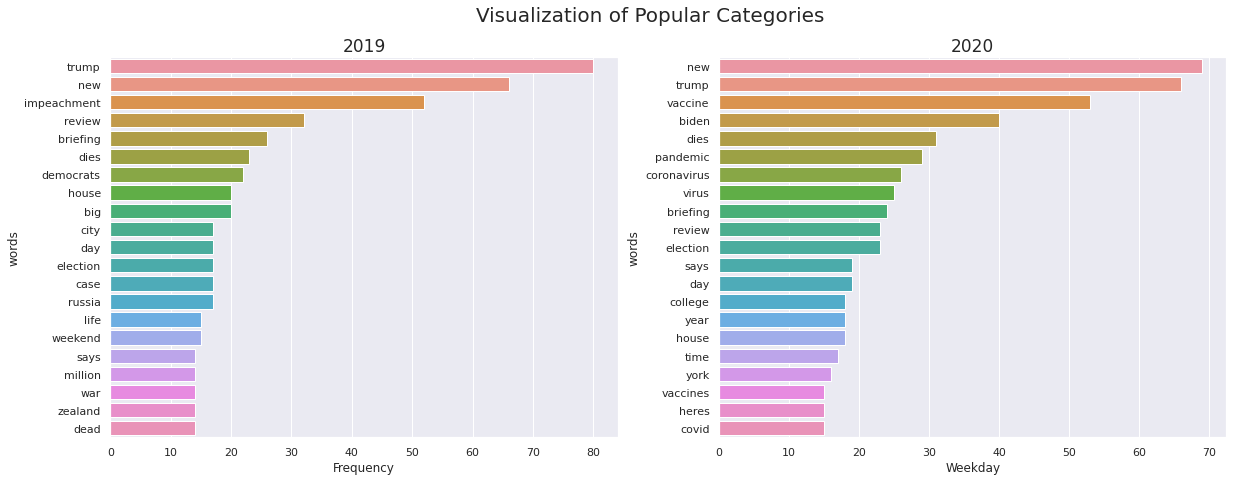

In [25]:
# visualize frequently occuring words
fig1, axes1 = plt.subplots(1, 2, figsize = (20,7))
fig1.suptitle('Visualization of Popular Categories',
              fontsize = 20)

sns.barplot(x=y1,y=x1, ax = axes1[0])
sns.barplot(x=y2,y=x2, ax = axes1[1])

axes1[0].set_title('2019', fontsize = 17)
axes1[0].set_xlabel('Frequency')
axes1[0].set_ylabel('words')

axes1[1].set_title('2020', fontsize = 17)
axes1[1].set_xlabel('Weekday')
axes1[1].set_ylabel('words')

In [26]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Step 5 : Interaction with the User
The user is asked for a topic name (for example, trump, corona etc.) and all the news items in the dataset which are related to it are displayed to the user along with their IDs. The user is then asked for an ID and the url against it is returned to the user.

In [27]:
# Ask user for topic name
topic_name = input ("Enter topic name :") 
# filter articles on that topic
articles = news_df.loc[news_df['title'].str.contains(topic_name.lower(), case=False)]
print(articles[['ID', 'title']].to_string(index=False))
# Get news ID
ID = input ("Enter article ID :")
# Return URL
print(articles[articles.ID == int(ID)].url.to_string(index=False)) 


Enter topic name :corona
      ID                                                                                         title
   20202                                          coronavirus briefing: vaccinations begin in the u.s.
   20207                                  did you get the coronavirus vaccine, or are you planning to?
  202045                                      canada and the coronavirus vaccine: here’s what it means
  202084                                        bicycling surges in manila amid coronavirus lockdowns.
 2020138                 do you want your parents and grandparents to get the new coronavirus vaccine?
 2020169                              germany locks down ahead of christmas as coronavirus deaths rise
 2020246                           first coronavirus vaccines head to states, starting historic effort
 2020284                                                     coronavirus briefing: what happened today
 2020323                         snow leopards a